<a href="https://colab.research.google.com/github/Saloni-2019/BasisOfLearning/blob/main/Copy_of_Sentiment_Analysis_of_Mental_health_posts_on_reddit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install datasets
!pip install datasets
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.7 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import torchtext
from torchtext.data import get_tokenizer

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
from datasets import load_dataset
dataset = load_dataset('solomonk/reddit_mental_health_posts')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/solomonk___csv/solomonk--reddit_mental_health_posts-ebd98f1303b315a0/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['author', 'body', 'created_utc', 'id', 'num_comments', 'score', 'subreddit', 'title', 'upvote_ratio', 'url'],
        num_rows: 151288
    })
})

In [ ]:
import pandas as pd
data = dataset['train']
df = pd.DataFrame(data)

In [ ]:
df

,author,body,created_utc,id,num_comments,score,subreddit,title,upvote_ratio,url
0,HotConversation1273,A few months ago I was accepted into this full...,2021-12-22T18:32:56.000Z,rmbjwb,1,1,ADHD,I get extremely anxious if I’m not working 24/7,1.00,https://www.reddit.com/r/ADHD/comments/rmbjwb/...
1,snorefestt,"Hey guys, I was curious if anyone else has the...",2021-12-22T18:24:25.000Z,rmbd1y,3,5,ADHD,"I can't will myself to clean my own house, but...",1.00,https://www.reddit.com/r/ADHD/comments/rmbd1y/...
2,etyf12,\n\ni have 6 exams in the next 2 weeks one of...,2021-12-22T18:22:52.000Z,rmbbvu,1,2,ADHD,i need some help,1.00,https://www.reddit.com/r/ADHD/comments/rmbbvu/...
3,GetHairOrDieTryin,Is there anyone out there that is struggling w...,2021-12-22T18:20:35.000Z,rmba1t,3,2,ADHD,Anyone up for a chat?,1.00,https://www.reddit.com/r/ADHD/comments/rmba1t/...
4,ZeroTransPat,"Whenever I get hungry, I never eat because I d...",2021-12-22T18:18:47.000Z,rmb8lm,2,1,ADHD,Figuring out what to eat sucks,1.00,https://www.reddit.com/r/ADHD/comments/rmb8lm/...
...,...,...,...,...,...,...,...,...,...,...
151283,mesu2713,The rescheduling and the waiting and the sheer...,2019-07-07T20:33:17.000Z,cablf1,2,3,ptsd,Anybody out there still waiting for your day i...,0.81,https://www.reddit.com/r/ptsd/comments/cablf1/...
151284,mooki24,"I experienced a stressful, drawn out event rec...",2019-07-07T17:28:34.000Z,ca9dkd,1,2,ptsd,PTSD-like symptoms?,0.67,https://www.reddit.com/r/ptsd/comments/ca9dkd/...
151285,[deleted],[deleted],2019-07-07T16:43:09.000Z,ca8ucl,2,16,ptsd,"I posted on here months ago and was blind, but...",1.00,https://www.reddit.com/r/ptsd/comments/ca8ucl/...
151286,[deleted],[deleted],2019-07-07T16:31:35.000Z,ca8pou,0,4,ptsd,Just a friendly reminder using facts,0.84,https://www.reddit.com/r/ptsd/comments/ca8pou/...


<Axes: >

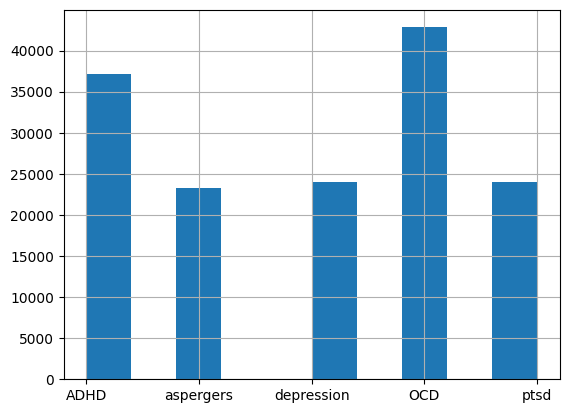

In [ ]:
df.subreddit.hist()

In [ ]:
df = df[~df.apply(lambda row: row.astype(str).str.contains('deleted').any(), axis=1)]

In [ ]:
df

,author,body,created_utc,id,num_comments,score,subreddit,title,upvote_ratio,url
0,HotConversation1273,A few months ago I was accepted into this full...,2021-12-22T18:32:56.000Z,rmbjwb,1,1,ADHD,I get extremely anxious if I’m not working 24/7,1.00,https://www.reddit.com/r/ADHD/comments/rmbjwb/...
1,snorefestt,"Hey guys, I was curious if anyone else has the...",2021-12-22T18:24:25.000Z,rmbd1y,3,5,ADHD,"I can't will myself to clean my own house, but...",1.00,https://www.reddit.com/r/ADHD/comments/rmbd1y/...
2,etyf12,\n\ni have 6 exams in the next 2 weeks one of...,2021-12-22T18:22:52.000Z,rmbbvu,1,2,ADHD,i need some help,1.00,https://www.reddit.com/r/ADHD/comments/rmbbvu/...
3,GetHairOrDieTryin,Is there anyone out there that is struggling w...,2021-12-22T18:20:35.000Z,rmba1t,3,2,ADHD,Anyone up for a chat?,1.00,https://www.reddit.com/r/ADHD/comments/rmba1t/...
4,ZeroTransPat,"Whenever I get hungry, I never eat because I d...",2021-12-22T18:18:47.000Z,rmb8lm,2,1,ADHD,Figuring out what to eat sucks,1.00,https://www.reddit.com/r/ADHD/comments/rmb8lm/...
...,...,...,...,...,...,...,...,...,...,...
151277,marblepalace77,Do ppl with PTSD also get paranoia like BPD ( ...,2019-07-08T00:29:14.000Z,cae5de,2,1,ptsd,PTSD and BPD and psychosis,0.67,https://www.reddit.com/r/ptsd/comments/cae5de/...
151282,kittyKATchaos,"On the 4th of July, I got really intoxicated a...",2019-07-07T20:42:07.000Z,cabp52,6,3,ptsd,How to cope and heal after a tramatic experien...,0.81,https://www.reddit.com/r/ptsd/comments/cabp52/...
151283,mesu2713,The rescheduling and the waiting and the sheer...,2019-07-07T20:33:17.000Z,cablf1,2,3,ptsd,Anybody out there still waiting for your day i...,0.81,https://www.reddit.com/r/ptsd/comments/cablf1/...
151284,mooki24,"I experienced a stressful, drawn out event rec...",2019-07-07T17:28:34.000Z,ca9dkd,1,2,ptsd,PTSD-like symptoms?,0.67,https://www.reddit.com/r/ptsd/comments/ca9dkd/...


In [ ]:
df.apply(lambda row: row.astype(str).str.contains('deleted').any(), axis=1)

0         False
1         False
2         False
3         False
4         False
          ...  
151277    False
151282    False
151283    False
151284    False
151287    False
Length: 97270, dtype: bool

In [ ]:
df.apply(lambda row: row.astype(str).str.contains('removed').any(), axis=1)

0         False
1         False
2         False
3         False
4         False
          ...  
151277    False
151282    False
151283    False
151284    False
151287    False
Length: 97270, dtype: bool

In [ ]:
df = df[~df.apply(lambda row: row.astype(str).str.contains('removed').any(), axis=1)]

In [ ]:
df

,author,body,created_utc,id,num_comments,score,subreddit,title,upvote_ratio,url
0,HotConversation1273,A few months ago I was accepted into this full...,2021-12-22T18:32:56.000Z,rmbjwb,1,1,ADHD,I get extremely anxious if I’m not working 24/7,1.00,https://www.reddit.com/r/ADHD/comments/rmbjwb/...
1,snorefestt,"Hey guys, I was curious if anyone else has the...",2021-12-22T18:24:25.000Z,rmbd1y,3,5,ADHD,"I can't will myself to clean my own house, but...",1.00,https://www.reddit.com/r/ADHD/comments/rmbd1y/...
2,etyf12,\n\ni have 6 exams in the next 2 weeks one of...,2021-12-22T18:22:52.000Z,rmbbvu,1,2,ADHD,i need some help,1.00,https://www.reddit.com/r/ADHD/comments/rmbbvu/...
3,GetHairOrDieTryin,Is there anyone out there that is struggling w...,2021-12-22T18:20:35.000Z,rmba1t,3,2,ADHD,Anyone up for a chat?,1.00,https://www.reddit.com/r/ADHD/comments/rmba1t/...
4,ZeroTransPat,"Whenever I get hungry, I never eat because I d...",2021-12-22T18:18:47.000Z,rmb8lm,2,1,ADHD,Figuring out what to eat sucks,1.00,https://www.reddit.com/r/ADHD/comments/rmb8lm/...
...,...,...,...,...,...,...,...,...,...,...
151277,marblepalace77,Do ppl with PTSD also get paranoia like BPD ( ...,2019-07-08T00:29:14.000Z,cae5de,2,1,ptsd,PTSD and BPD and psychosis,0.67,https://www.reddit.com/r/ptsd/comments/cae5de/...
151282,kittyKATchaos,"On the 4th of July, I got really intoxicated a...",2019-07-07T20:42:07.000Z,cabp52,6,3,ptsd,How to cope and heal after a tramatic experien...,0.81,https://www.reddit.com/r/ptsd/comments/cabp52/...
151283,mesu2713,The rescheduling and the waiting and the sheer...,2019-07-07T20:33:17.000Z,cablf1,2,3,ptsd,Anybody out there still waiting for your day i...,0.81,https://www.reddit.com/r/ptsd/comments/cablf1/...
151284,mooki24,"I experienced a stressful, drawn out event rec...",2019-07-07T17:28:34.000Z,ca9dkd,1,2,ptsd,PTSD-like symptoms?,0.67,https://www.reddit.com/r/ptsd/comments/ca9dkd/...


In [ ]:
df_1 = df[['body','subreddit']]

In [ ]:
df_1

,body,subreddit
0,A few months ago I was accepted into this full...,ADHD
1,"Hey guys, I was curious if anyone else has the...",ADHD
2,\n\ni have 6 exams in the next 2 weeks one of...,ADHD
3,Is there anyone out there that is struggling w...,ADHD
4,"Whenever I get hungry, I never eat because I d...",ADHD
...,...,...
151277,Do ppl with PTSD also get paranoia like BPD ( ...,ptsd
151282,"On the 4th of July, I got really intoxicated a...",ptsd
151283,The rescheduling and the waiting and the sheer...,ptsd
151284,"I experienced a stressful, drawn out event rec...",ptsd


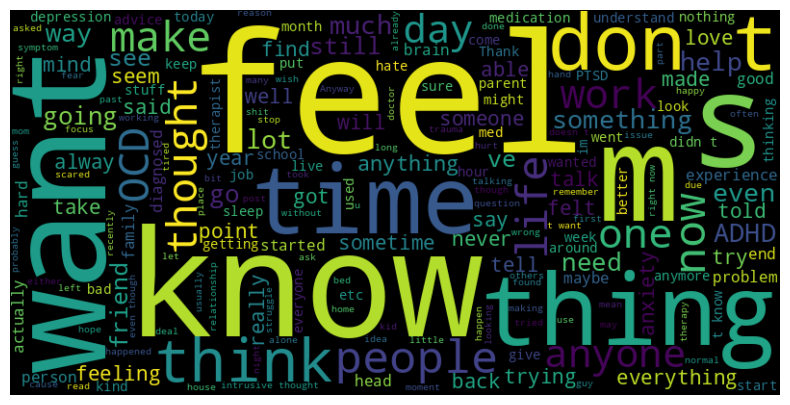

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
text = df_1['body'].str.cat(sep=' ')

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400).generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
print(text)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
adhd = df_1[df_1['subreddit'] == 'ADHD']
adhd

,body,subreddit
0,A few months ago I was accepted into this full...,ADHD
1,"Hey guys, I was curious if anyone else has the...",ADHD
2,\n\ni have 6 exams in the next 2 weeks one of...,ADHD
3,Is there anyone out there that is struggling w...,ADHD
4,"Whenever I get hungry, I never eat because I d...",ADHD
...,...,...
37100,TW: I do self medicate with alcohol to some ex...,ADHD
37102,Evaluation Or Appointment Help\n\n17m i need h...,ADHD
37105,Since the DSM was recently updated. ADD now fa...,ADHD
37107,I have these meds that I have to take in the m...,ADHD


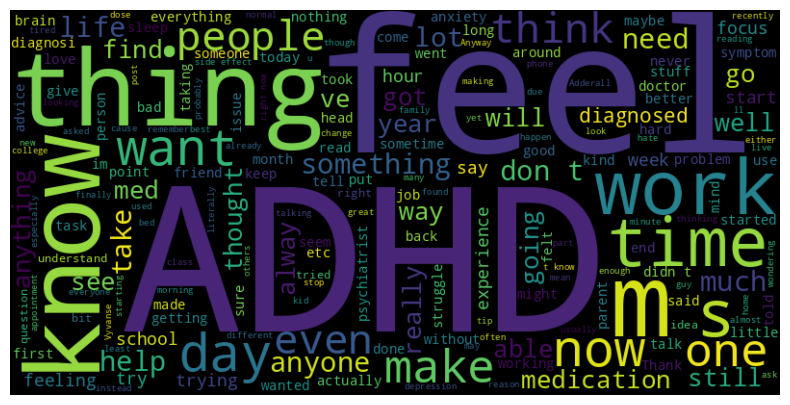

In [ ]:
text = adhd['body'].str.cat(sep=' ')

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400).generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
ptsd = df_1[df_1['subreddit'] == 'ptsd']
ptsd

,body,subreddit
127260,This year felt like literal hell. It’s over no...,ptsd
127261,Can feel my skin tightening up as I type this ...,ptsd
127262,I shout at my animals sometimes when they do s...,ptsd
127263,I'm really struggling with my past and it's pr...,ptsd
127264,On Snapchat call,ptsd
...,...,...
151277,Do ppl with PTSD also get paranoia like BPD ( ...,ptsd
151282,"On the 4th of July, I got really intoxicated a...",ptsd
151283,The rescheduling and the waiting and the sheer...,ptsd
151284,"I experienced a stressful, drawn out event rec...",ptsd


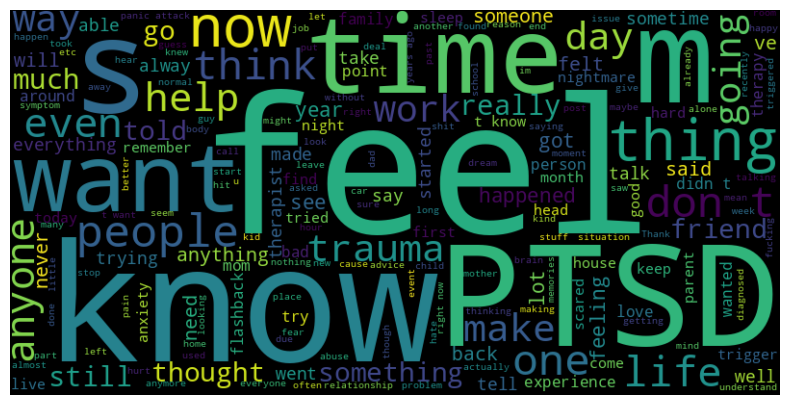

In [ ]:
text = ptsd['body'].str.cat(sep=' ')

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400).generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

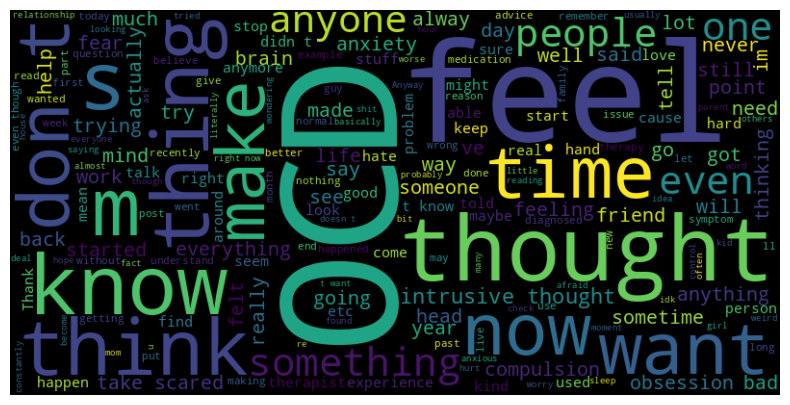

In [ ]:
ocd = df_1[df_1['subreddit'] == 'OCD']
text = ocd['body'].str.cat(sep=' ')

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400).generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

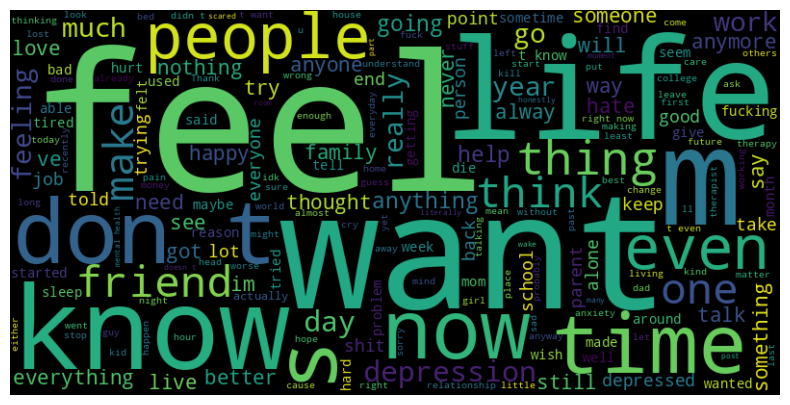

In [ ]:
dep = df_1[df_1['subreddit'] == 'depression']
text = dep['body'].str.cat(sep=' ')

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400).generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

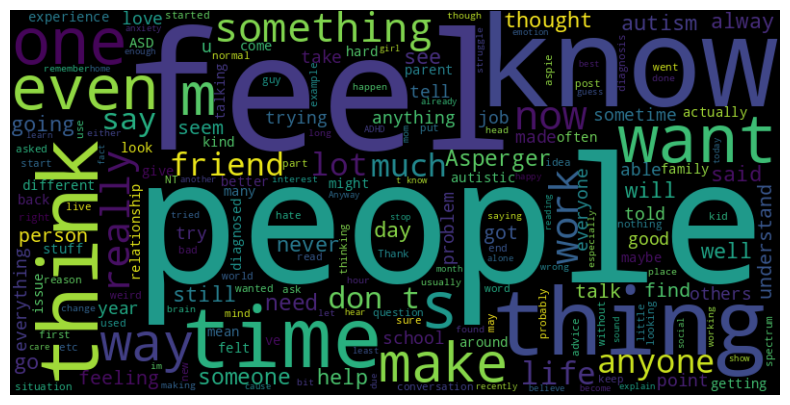

In [ ]:
asp = df_1[df_1['subreddit'] == 'aspergers']
text = asp['body'].str.cat(sep=' ')

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400).generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# removing next line \n from dataframe
df_1 = df_1.replace('\n', ' ', regex=True)

# Preparing dataset for train and test set

In [ ]:
df_1 = df_1.dropna(subset="body")

In [ ]:
# shuffle the data
df_1 = df_1.sample(frac=1, random_state=2023)
print(df_1.head)

X = df_1.body.values
print(X.shape)
y = df_1.subreddit.values
print(y[:5])
print(y.shape)

<bound method NDFrame.head of                                                      body   subreddit
139885  My dad died last year, of a heart attack, I wa...        ptsd
122106  Researchers at McMaster University are interes...         OCD
2944    I’ve always had really really bad anxiety. The...        ADHD
81742   I blog, participate in NaNoWriMo, but I never ...  depression
5006    hi, so i’m fairly new to reddit and the adhd w...        ADHD
...                                                   ...         ...
145739  Every single day I have to see the guy who rap...        ptsd
53644   I have had Asperger's ever since I was born my...   aspergers
139456  I’m new to this subreddit. Ptsd is something I...        ptsd
10507   I have a hard time paying attention to convers...        ADHD
106942  I was masturbating yesterday trying to keep th...         OCD

[82665 rows x 2 columns]>
(82665,)
['ptsd' 'OCD' 'ADHD' 'depression' 'ADHD']
(82665,)


In [ ]:
df_1.isnull().sum()

body         0
subreddit    0
dtype: int64

In [ ]:
# Split the data into train and test
x_train_text, x_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

In [ ]:
for s, l in zip(x_train_text[:5], y_train[:5]):
  print('{}: {}'.format(l, s))

OCD: Now I’m terrified that my iphone is infected with malware of some sort, because I clicked on a weird youtube ad that took me to a suspicious website. It’s really stressing me out and I’m all paranoid. I know viruses aren’t possible on an iPhone, but I think other malware is. I’ve never jailbroken my phone so idk if I should be worried? God I sound stupid LMAO.
ADHD: Yesterday I spent 4 hours on Reddit just making one post and responding to some people's comments.  Edit: This took me like 1hr15min. Which is actually good, I finished phase 1 of adding anything important you need to know, and was supposed to do phase 2 of cutting it down and grammar but I was hoping maybe this is the one time it's okay to include lots of details because I need the best advice I can get, since this is affecting me so much? At this point my life is college, work, and reddit. Which actually, I'm behind in all my classes now. "omg omg I have to go study right now but I can't until I post/perfect this." I

In [ ]:
tokenizer = get_tokenizer("basic_english")

print('Before Tokenize: ', x_train_text[1])
print('After Tokenize: ', tokenizer(x_train_text[1]))

Before Tokenize:  Yesterday I spent 4 hours on Reddit just making one post and responding to some people's comments.  Edit: This took me like 1hr15min. Which is actually good, I finished phase 1 of adding anything important you need to know, and was supposed to do phase 2 of cutting it down and grammar but I was hoping maybe this is the one time it's okay to include lots of details because I need the best advice I can get, since this is affecting me so much? At this point my life is college, work, and reddit. Which actually, I'm behind in all my classes now. "omg omg I have to go study right now but I can't until I post/perfect this." I'm getting desperate  \*\*Tldr; Since about 2 months ago I spend too much time on posts (2-3hrs) and comments (can be up to 1hr) because I need to perfect everything I write. I stopped visiting the reddit homepage so I save time, but I still waste time on my own posts and people who comment on my posts. I can't delete my reddit account or app; I actually

In [ ]:
x_train_token = [tokenizer(s) for s in tqdm(x_train_text)]
x_test_token = [tokenizer(s) for s in tqdm(x_test_text)]

  0%|          | 0/66132 [00:00<?, ?it/s]

  0%|          | 0/16533 [00:00<?, ?it/s]

In [ ]:
words = Counter()
for s in x_train_token:
  for w in s:
    words[w] += 1

sorted_words = list(words.keys())
sorted_words.sort(key=lambda w: words[w], reverse=True)
print(f"Number of different Tokens in our Dataset: {len(sorted_words)}")
print(sorted_words[:100])

Number of different Tokens in our Dataset: 104309
['i', '.', ',', 'to', 'and', 'the', 'a', "'", 'my', 'it', 'of', 'that', 'me', 'in', 'but', 'have', 'for', 'is', 'this', 'with', 'was', 'just', 'so', 'like', 't', 'on', '?', 'or', 'not', 'be', 'do', 'you', 'if', 'm', 'about', 'feel', 'can', 'at', 'as', 's', 'because', ')', 'what', 'i’m', '(', 'all', 'get', 'when', 'know', 'been', 'had', 'up', 'out', 'they', 'am', 'how', 'time', 'are', 'even', 'really', 'he', 'now', 'want', 'people', 'from', 'don', 'she', 'myself', 'would', 'an', 'has', 'them', 'things', 'one', 'life', 've', 'more', 'think', 'some', 'her', 'there', 'no', 'any', 'something', 'ocd', 'being', 'don’t', 'much', 'then', 'it’s', 'also', 'we', '!', 'will', 'anyone', 'go', 'day', 'never', 'going', 'help']


In [ ]:
count_occurences = sum(words.values())

accumulated = 0
counter = 0

while accumulated < count_occurences * 0.8:
  accumulated += words[sorted_words[counter]]
  counter += 1

print(f"The {counter * 100 / len(words)}% most common words "
      f"account for the {accumulated * 100 / count_occurences}% of the occurrences")

The 0.4525017016748315% most common words account for the 80.01091809033078% of the occurrences


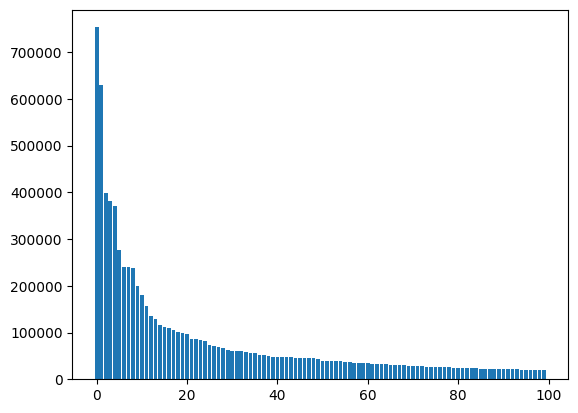

In [ ]:
plt.bar(range(100), [words[w] for w in sorted_words[:100]])
plt.show()

# Step 4: choose toolkit
Our goal is to train a model capable of estimating the sentiment of a tweet (positive or negative) by reading its content. To that end we will try 2 different approaches:

A logistic regression using sklearn. NOTE: it can probaly work better than an SVM model.

A simple Embedding + RNN.



## logistic regression

In [ ]:
vectorizer = CountVectorizer(binary=True)
x_train_cv = vectorizer.fit_transform(x_train_text)
x_test_cv = vectorizer.transform(x_test_text)

In [1]:
%%capture
!pip install transformers
!pip install datasets
!pip install transformers[torch]
!pip install accelerate
!pip install huggingface_hub

In [2]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset
import numpy as np
import torch

dataset = load_dataset("solomonk/reddit_mental_health_posts")

def not_none(example):
    return example['body'] is not None

dataset = dataset.filter(not_none)

dataset_sampled = dataset['train'].train_test_split(test_size=0.7, seed=2023)['train']

train_val_test = dataset_sampled.train_test_split(test_size=0.2, seed=2023)
train_dataset = train_val_test['train']
test_val_dataset = train_val_test['test']

test_val_split = test_val_dataset.train_test_split(test_size=0.5, seed=2023)
validation_dataset = test_val_split['train']
test_dataset = test_val_split['test']

columns_to_keep = ['body', 'subreddit']

columns_to_remove = [col for col in dataset_sampled.column_names if col not in columns_to_keep]

train_dataset = train_dataset.remove_columns(columns_to_remove)
validation_dataset = validation_dataset.remove_columns(columns_to_remove)
test_dataset = test_dataset.remove_columns(columns_to_remove)

le = LabelEncoder()

le.fit(dataset_sampled['subreddit'])

def encode_labels(example):
    example['subreddit'] = le.transform([example['subreddit']])[0]
    return example

train_dataset = train_dataset.map(encode_labels)
validation_dataset = validation_dataset.map(encode_labels)
test_dataset = test_dataset.map(encode_labels)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def prepare_data(example):
    encoding = tokenizer.encode_plus(
        example['body'],
        truncation=True,
        padding='max_length',
        max_length=512,
        return_tensors='pt',
    )
    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': torch.tensor(example['subreddit'], dtype=torch.long)
    }

train_dataset = train_dataset.map(prepare_data)
validation_dataset = validation_dataset.map(prepare_data)
test_dataset = test_dataset.map(prepare_data)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
validation_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    # output_dir="./output",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
)

trainer.train()

trainer.evaluate(test_dataset)


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/solomonk___csv/solomonk--reddit_mental_health_posts-ebd98f1303b315a0/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Filter:   0%|          | 0/151288 [00:00<?, ? examples/s]

Map:   0%|          | 0/35922 [00:00<?, ? examples/s]

Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

Map:   0%|          | 0/4491 [00:00<?, ? examples/s]

Map:   0%|          | 0/35922 [00:00<?, ? examples/s]

Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

Map:   0%|          | 0/4491 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,1.234000
1000,0.986000
1500,0.929400
2000,0.914100
2500,0.846200
3000,0.795300
3500,0.803300
4000,0.791200


{'eval_loss': 0.8677850961685181,
 'eval_runtime': 145.0176,
 'eval_samples_per_second': 30.969,
 'eval_steps_per_second': 1.938,
 'epoch': 2.0}

In [3]:
from huggingface_hub import notebook_login
notebook_login()

In [4]:
trainer.push_to_hub("bert_classification_reddit")

RepositoryNotFoundError: ignored